# Recurrent Neural Nets - Sentiment Analysis

There is a branch of Deep Learning that is dedicated to processing time series. These deep Nets are **Recursive Neural Nets (RNNs)**. LSTMs are one of the few types of RNNs that are available. Gated Recurent Units (GRUs) are the other type of popular RNNs.

This is an illustration from http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (A highly recommended read)

![RNNs](./images/RNN-unrolled.png)

In lesson 5 we looked at getting the sentiment of a given movie review. The data comes from a IMDB review set where a rating of less than 5 was classified as negative and greater than 5 as positive. Neutral reviews were ignored.

In the previous lesson we considered a Bag of Words (BoW) model where the emphasis is on how many times a particular word appeared in the sentence/ review. This worked fairly well giving around 80% accuracy.

One thing that was missing was the structure of the sentence. The word order was not taken into account. For example a sentence such as this: "I wanted to hate it so much but I loved the movie." would probably confuse the previous model. Simply because 'love' and 'hate' are both included in the sentence. There were other preprocessing steps done such as stemming (eg. hated -> hate, runner -> run) which will not be done in this lesson. We will maintain structure and feed in a number representation of words in order into our DL model.

<img src="./images/happy_trump.png" alt="happy" style="width: 150px;"/><img src="./images/sad_trump.png" alt="sad" style="width: 150px;"/>

## References
1. Similar work done for a fake news classifier: https://blog.kjamistan.com/comparing-scikit-learn-text-classifiers-on-a-fake-news-dataset/


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape
from keras.models import load_model, model_from_json

from sklearn.model_selection import train_test_split

import os
import urllib

from collections import Counter

Using TensorFlow backend.


In [2]:
!mkdir -p data

In [4]:
if not os.path.isfile('data/reviews2.pkl'):
    urllib.request.urlretrieve('https://www.dropbox.com/s/15tfttuzqe7fimg/reviews2.pkl?dl=1','data/reviews2.pkl') 

Preprocessing steps: lower case, remove urls, some punctuations etc.

In [5]:
df = pd.read_pickle('data/reviews2.pkl')
df.Reviews = df.Reviews.str.lower()
df.Reviews = df.Reviews.str.replace(r'http[\w:/\.]+','') # remove urls
df.Reviews = df.Reviews.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.Reviews = df.Reviews.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.Reviews = df.Reviews.str.replace(r'\.',' .') #replace multple periods with a single one
df.Reviews = df.Reviews.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.Reviews = df.Reviews.str.strip() 
print(df.shape)
df.head()

(25000, 2)


,Reviews,Sentiment
0,bromwell high is a cartoon comedy . it ran at ...,1
1,homelessness or houselessness as george carlin...,1
2,brilliant overacting by lesley ann warren . be...,1
3,this is easily the most underrated film inn th...,1
4,this is not the typical mel brooks film . it w...,1


In [6]:
df.Reviews.values[0]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life such as teachers . my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers . the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled . at . high . a classic line inspector im here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isnt'

Get all the unique words. We will only consider words that have been used more than 5 times. Finally from this we create a dictionary mapping words to integers.

Once this is done we will create a list of reviews where the words are converted to ints.

In [7]:
all_text = ' '.join(df.Reviews.values)
words = all_text.split()
u_words = Counter(words).most_common()
u_words = [word[0] for word in u_words if word[1]>5] # we will only consider words that have been used more than 5 times
# create the dictionary
word2num = dict(zip(u_words,range(len(u_words))))
word2num['<Other>'] = len(u_words)
num2word = dict(zip(word2num.values(), word2num.keys()))

int_text = [[word2num[word] if word in word2num else len(u_words) for word in Review.split()] for Review in df.Reviews.values]

print('The number of unique words are: ', len(u_words))
print('The first review looks like this: ')
print(int_text[0][:20])

The number of unique words are:  27915
The first review looks like this: 
[22054, 323, 6, 3, 1074, 217, 1, 8, 2102, 32, 0, 167, 59, 14, 47, 81, 5531, 43, 400, 118]


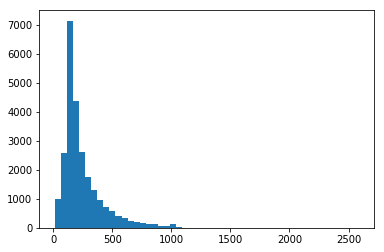

In [8]:
plt.hist([len(t) for t in int_text],50)
plt.show()

In [9]:
print('The number of reviews greater than 500 in length is: ', np.sum(np.array([len(t)>500 for t in int_text])))
print('The number of reviews less than 50 in length is: ', np.sum(np.array([len(t)<50 for t in int_text])))

The number of reviews greater than 500 in length is:  2234
The number of reviews less than 50 in length is:  411


You cannot pass differing lengths of sentences to the algorithm. Hence we shall prepad the sentence with `<PAD>`. Sequences less than 500 in length will be prepadded and sequences that are longer than 500 will be truncated. It is assumed that the sentiment of the review can be asserted from the first 500 words.

In [10]:
num2word[len(word2num)] = '<PAD>'
word2num['<PAD>'] = len(word2num)

for i, t in enumerate(int_text):
    if len(t)<500:
        int_text[i] = [word2num['<PAD>']]*(500-len(t)) + t
    elif len(t)>500:
        int_text[i] = t[:500]
    else:
        continue

x = np.array(int_text)
y = df.Sentiment.values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

## Many to One LSTM

In [11]:
model = Sequential()
model.add(Embedding(len(word2num), 32)) # , batch_size=batch_size
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          893344    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 918,241
Trainable params: 918,241
Non-trainable params: 0
_________________________________________________________________


In [12]:
batch_size = 128
model.fit(X_train, y_train, batch_size=batch_size, epochs=2)

Epoch 1/2
22500/22500 [==============================] - 179s 8ms/step - loss: 0.6001 - acc: 0.6966
Epoch 2/2
22500/22500 [==============================] - 157s 7ms/step - loss: 0.2888 - acc: 0.8813


The first number below is the loss and the second value onwards is whatever metrics you have used, in this case it is the accuracy. Important to set the `batch_size` as well since evaluation can be slower for default size (32).

In [13]:
model.evaluate(X_test, y_test, batch_size=batch_size)

2500/2500 [==============================] - 7s 3ms/step


[0.27450007939338683, 0.89479999942779542]

In [14]:
X_test[0,:]

array([27916, 27916, 27916, 27916, 27916, 27916, 27916, 27916, 27916,
       27916, 27916, 27916, 27916, 27916, 27916,     7,  3848,     7,
           0,  1881,   726,  3247,   289,  1246,  1210,     1,  2964,
        1030,    37,    44,    25,  1283, 22951,  7472,    16,     3,
        3590,    11,  1320,  3220,     1,    14,  1036,   717,  1709,
        2849,   740,    46,     0,   230,  1103,    36,   105,  3531,
           7,     0,  4668,     1,   176,    22,     0,  1842,   129,
           0,   105,     4,    94,   399,  8951,  5448,     7,    34,
         761,     5,   162,     0,  1773,     2,   250,   321,  3894,
           5,     0,  3543,    19,    12,    14,    13,  3304,    46,
          33,   100,   595,     4,    82,    15,    47,   272,   172,
       13418,  7067,   117,    22,  1379,     5,   175,     0,   390,
         514,    16,   250,    11,   918,    39,   496,    36, 14725,
           1,   252,    75,     5,   156,  5102,   115,     0,    64,
         299,   267,

In [15]:
model.predict(X_test[0][None,:])

array([[ 0.98170358]], dtype=float32)

In [16]:
y_test[0]

1

In [17]:
X_test.shape

(2500, 500)

In [18]:
X_test[0][None,:].shape

(1, 500)

In [19]:
sentence = "donald trump . ".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

array([[ 0.55422628]], dtype=float32)

In [20]:
word2num['washington']

2000

In [21]:
model.get_weights()[0][word2num['trump']]

array([-0.01726139, -0.04959514,  0.04721377, -0.01896544,  0.03904107,
       -0.05339386, -0.0318684 ,  0.04673713, -0.04334692, -0.04567495,
        0.03542164, -0.01118277, -0.03033838,  0.01233505,  0.03414015,
       -0.00682862,  0.04984694,  0.00596975, -0.05482409,  0.00929336,
       -0.00303048, -0.04176805,  0.01059499,  0.0565246 , -0.0558453 ,
       -0.00546785, -0.04133826,  0.00916991,  0.05849088, -0.05174542,
        0.00778678, -0.00449359], dtype=float32)

In [22]:
model.get_weights()[0][word2num['hitler']]

array([-0.0087095 , -0.04241782,  0.01230696, -0.03714038, -0.06135994,
        0.00760195,  0.02777364,  0.07299132, -0.06609873, -0.02097359,
        0.01137068,  0.01731196,  0.03382057, -0.0036195 , -0.0306195 ,
        0.05178453, -0.01523854,  0.00716526, -0.0335728 , -0.07671038,
        0.02215168,  0.00062636, -0.00311515, -0.07438745, -0.00466766,
       -0.00450422, -0.03426327,  0.06381596, -0.01512961, -0.02493496,
        0.07057063,  0.01613435], dtype=float32)

In [22]:
model.get_weights()[0][word2num['<PAD>']]

array([-0.00042697,  0.02666594,  0.00539789,  0.00934576, -0.00378692,
        0.02564251,  0.04248873,  0.03831405, -0.00569457, -0.03243225,
        0.01039807,  0.01550463,  0.02280113, -0.05804716,  0.01169127,
       -0.01287616, -0.03764107,  0.02296564, -0.01055763, -0.03860405,
       -0.04602284,  0.0618933 , -0.03801853, -0.01890442,  0.03961621,
        0.02046974, -0.03808747, -0.02318501, -0.04816858, -0.00388916,
        0.04502256, -0.02875248], dtype=float32)

In [23]:
model.get_weights()[0].shape

(27917, 32)